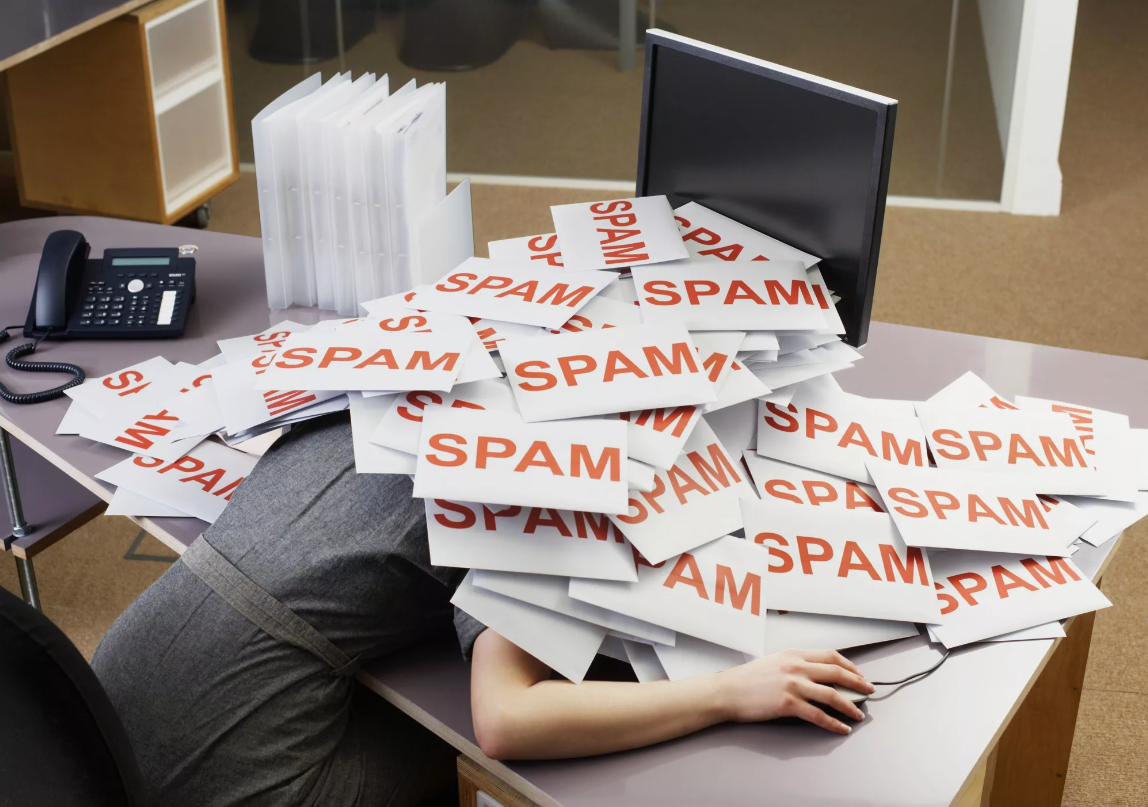

**Spam prediction** - вэб сервис, позволяющий онлайн определить, является ли сообщение спам рассылкой. Все сообщения можно проссматривать, добавлять новые, обновлять и удалять.

1. Загрузка библиотек

In [ ]:
!pip install autokeras==1.1.0 tensorflow==2.15.1 keras-nlp==0.5.1
!pip install fastapi
!pip install uvicorn
!pip install python-multipart

2. Загрузка обученной модели и определение функции для предсказания

In [ ]:
%%writefile spam_model.py
import os
from keras.models import load_model
import autokeras as ak
from typing import Literal


MODEL_PATH = 'spam_classifier.keras'
model = load_model(MODEL_PATH, custom_objects=ak.CUSTOM_OBJECTS)

def predict_text(model, text: str) -> Literal["spam", "ham"]:
    prediction = model.predict([text])
    return "spam" if prediction[0][0] > 0.5 else "ham"

Writing spam_model.py


3. Так как при обучении модели текст был отдельно подготовлен и очищен, то и здесь определяем функцию для предобработки текста

In [ ]:
%%writefile preprocess.py
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk


nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)


def preprocess_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    return text

Writing preprocess.py


4. Определение модели для предсказанного текста

In [ ]:
%%writefile models.py
from pydantic import BaseModel


class SpamRequest(BaseModel):
    text: str

Writing models.py


4. Ручка для онлайн определения категории сообщения по адресу /predict

In [ ]:
%%writefile prediction.py
from fastapi import APIRouter
from models import SpamRequest
from spam_model import model, predict_text
from preprocess import preprocess_text


router = APIRouter()


async def get_prediction(text: str) -> str:
       preprocessed_text = preprocess_text(text)
       label = predict_text(model, preprocessed_text)
       return label


@router.post("/predict",
             summary="Предсказание",
             description="Предсказывает, является ли сообщение спамом")
async def predict_spam(request: SpamRequest) -> dict:
    label = await get_prediction(request.text)
    return {"text": request.text, "label": label}

Writing prediction.py


5. Ручки для просмотра всего списка сообщений, просмотра одного сообщения по ID, добавления/обновления/удаления сообщений. Для учебных целей, для хранения записей используется переменная data_storage.

In [ ]:
%%writefile crud.py
from fastapi import APIRouter, HTTPException
from models import SpamRequest
from prediction import get_prediction


router = APIRouter()


data_storage = [
    {
        "id": 1,
        "text": "Hello! How are you?",
        "label": "ham"
    },
    {
        "id": 2,
        "text": "Congratulations! You've won a prize!",
        "label": "spam"
    }
]


@router.get("/data",
            summary="Список сообщений",
            description="Получение списка сообщений из базы")
async def read_data() -> dict:
    return {"data": data_storage}


@router.post("/data",
             summary="Добавление сообщений",
             description="Добавление сообщений в базу")
async def create_data(request: SpamRequest):
    label = await get_prediction(request.text)
    new_entry = {
        "id": len(data_storage) + 1,
        "text": request.text,
        "label": label,
    }
    data_storage.append(new_entry)

    return {"message": "Сообщение добавлено.", "message": new_entry}


@router.get("/data/{item_id}",
             summary="Поиск сообщений",
             description="Поиск сообщений в базе по id")
async def read_single_data(item_id: int) -> dict:
    for item in data_storage:
        if item["id"] == item_id:
            return {"message": item}

    raise HTTPException(status_code=404, detail="Сообщение не найдено.")


@router.put("/data/{item_id}",
             summary="Обновление сообщений",
             description="Обновление сообщений в базе")
async def update_data(item_id: int, request: SpamRequest):
    for item in data_storage:
        if item["id"] == item_id:
            label = await get_prediction(request.text)
            item["text"] = request.text
            item["label"] = label
            return {"message": "Сообщение обновлено", "message": item}

    raise HTTPException(status_code=404, detail="Сообщение не найдено.")


@router.delete("/data/{item_id}",
             summary="Удаление сообщений",
             description="Удаление сообщений из базы")
async def delete_data(item_id: int):
    global data_storage
    for i in data_storage:
        if i["id"] == item_id:
            data_storage = [i for i in data_storage if i["id"] != item_id]
            return {"message": "Сообщение удалено."}

    raise HTTPException(status_code=404, detail="Сообщение не найдено.")

Writing crud.py


6. Входной модуль. Определена ручка для главной страницы с описанием сервиса

In [ ]:
%%writefile main.py
from fastapi import FastAPI
import prediction
import crud


app = FastAPI()


app.include_router(prediction.router)
app.include_router(crud.router)


@app.get("/",
         summary="Описание API",
         description="Описание программы")
async def read_root():
    return {
    "message": (
        "API для обнаружения спама в сообщениях. "
        "Можно просматривать/добавлять/обновлять/удалять сообщения."
    )
}

Writing main.py


# Пример работы

1. Запуск сервиса

In [ ]:
!nohup uvicorn main:app --reload &

nohup: appending output to 'nohup.out'


2. Проссмотр главной страницы

In [ ]:
import requests
r = requests.get('http://127.0.0.1:8000/')
print(r.status_code)
print(r.text)

200
{"message":"API для обнаружения спама в сообщениях. Можно проссматривать/добавлять/обновлять/удалять сообщения."}


3. Получение списка всех записей

In [ ]:
BASE_URL = 'http://127.0.0.1:8000'

r = requests.get(f'{BASE_URL}/data')
data = r.json()["data"]

print("\n=== Получение всех записей ===")
for message in data:
    print(f"ID: {message['id']}, Текст: {message['text']}, "
          f"Метка: {message['label']}")


=== Получение всех записей ===
ID: 1, Текст: Hello! How are you?, Метка: ham
ID: 2, Текст: Congratulations! You've won a prize!, Метка: spam


4. Получение одной записи

In [ ]:
if len(data) > 1:
    message_id = data[0]['id']
    r = requests.get(f'{BASE_URL}/data/{message_id}')
    single_message = r.json()["message"]

    print("\n=== Получение одной записи ===")
    print(f"ID: {single_message['id']}, Текст: {single_message['text']}, "
          f"Метка: {single_message['label']}")


=== Получение одной записи ===
ID: 1, Текст: Thank you for choosing our store., Метка: ham


5. Предсказание спама

In [ ]:
text_to_predict = "URGENT! You've won a trip to Africa!"
payload = {"text": text_to_predict}
r = requests.post(f'{BASE_URL}/predict', json=payload)
prediction_result = r.json()

print("\n=== Предсказание спама ===")
print(f"Текст: {prediction_result['text']}, "
      f"Метка: {prediction_result['label']}")


=== Предсказание спама ===
Текст: URGENT! You've won a trip to Africa!, Метка: spam


In [ ]:
text_to_predict = "I'm waiting for your call."
payload = {"text": text_to_predict}
r = requests.post(f'{BASE_URL}/predict', json=payload)
prediction_result = r.json()

print("\n=== Предсказание спама ===")
print(f"Текст: {prediction_result['text']}, "
      f"Метка: {prediction_result['label']}")


=== Предсказание спама ===
Текст: I'm waiting for your call., Метка: ham


6. Добавление новой записи

In [ ]:
new_message = {"text": "I am responding to your letter, I am glad that you wrote"}
r = requests.post(f'{BASE_URL}/data', json=new_message)
added_message = r.json()["message"]

print("\n=== Добавление новой записи ===")
print(f"Добавлена запись: ID: {added_message['id']}, "
      f"Текст: {added_message['text']}, Метка: {added_message['label']}")


=== Добавление новой записи ===
Добавлена запись: ID: 5, Текст: I am responding to your letter, I am glad that you wrote, Метка: ham


7. Обновление записи

In [ ]:
if data:
    message_id = data[0]['id']
    update_message = {"text": "Thank you for choosing our store."}
    r = requests.put(f'{BASE_URL}/data/{message_id}', json=update_message)
    updated_message = r.json()["message"]

    print("\n=== Обновление записи ===")
    print(f"Обновлено: ID: {updated_message['id']}, "
          f"Текст: {updated_message['text']}, "
          f"Метка: {updated_message['label']}")


=== Обновление записи ===
Обновлено: ID: 1, Текст: Thank you for choosing our store., Метка: ham


8. Удаление записи

In [ ]:
if data:
    message_id = data[1]['id']
    r = requests.delete(f'{BASE_URL}/data/{message_id}')
    print("\n=== Удаление записи ===")
    print(f"Удалена запись с ID: {message_id}")


=== Удаление записи ===
Удалена запись с ID: 2


# Просмотр документации

In [ ]:
!ssh -o "StrictHostKeyChecking no" -R 80:localhost:8000 serveo.net

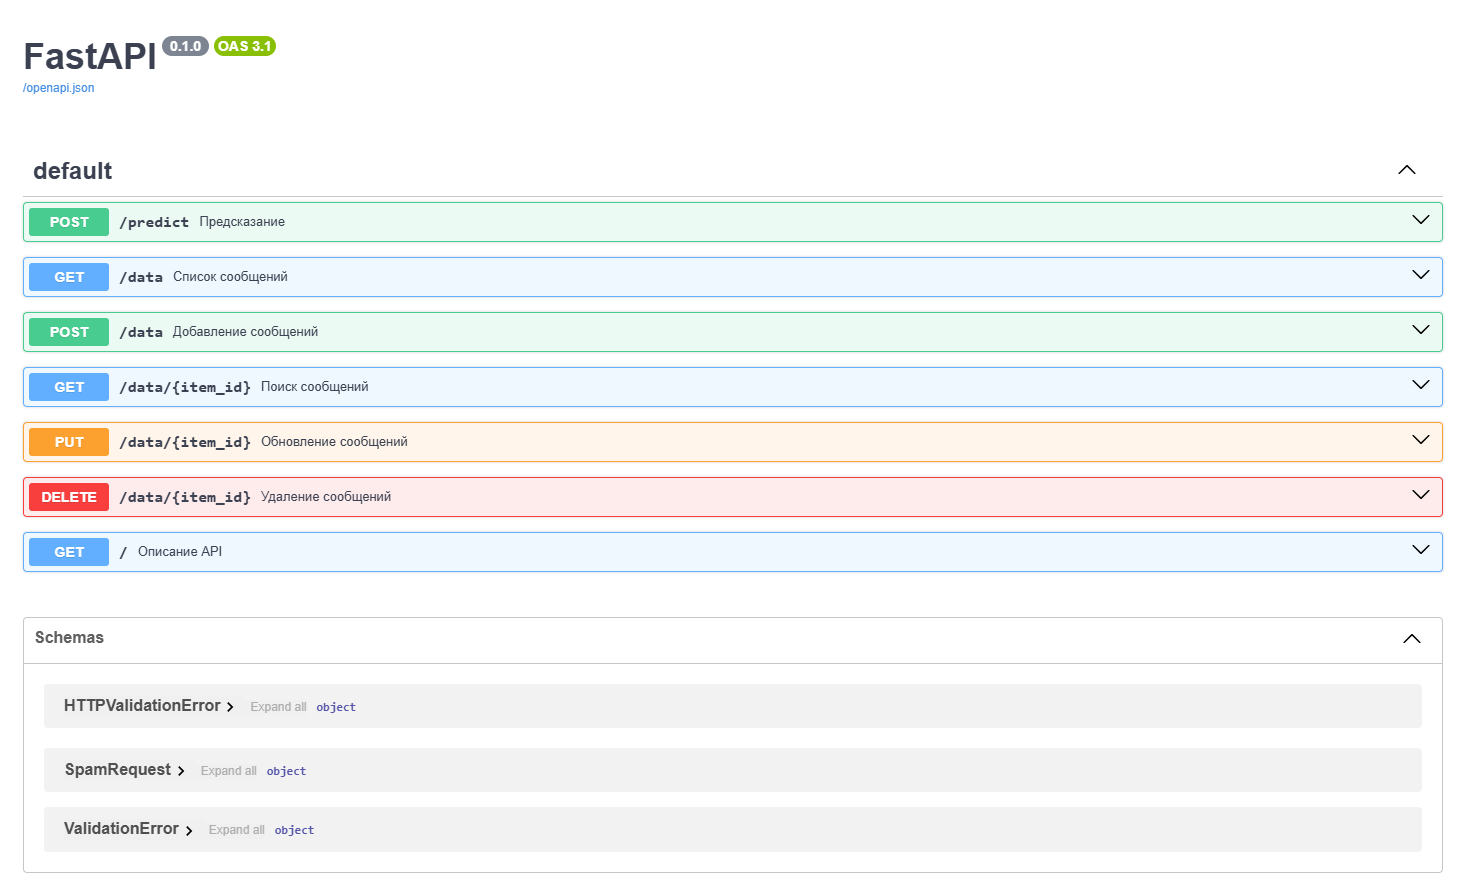

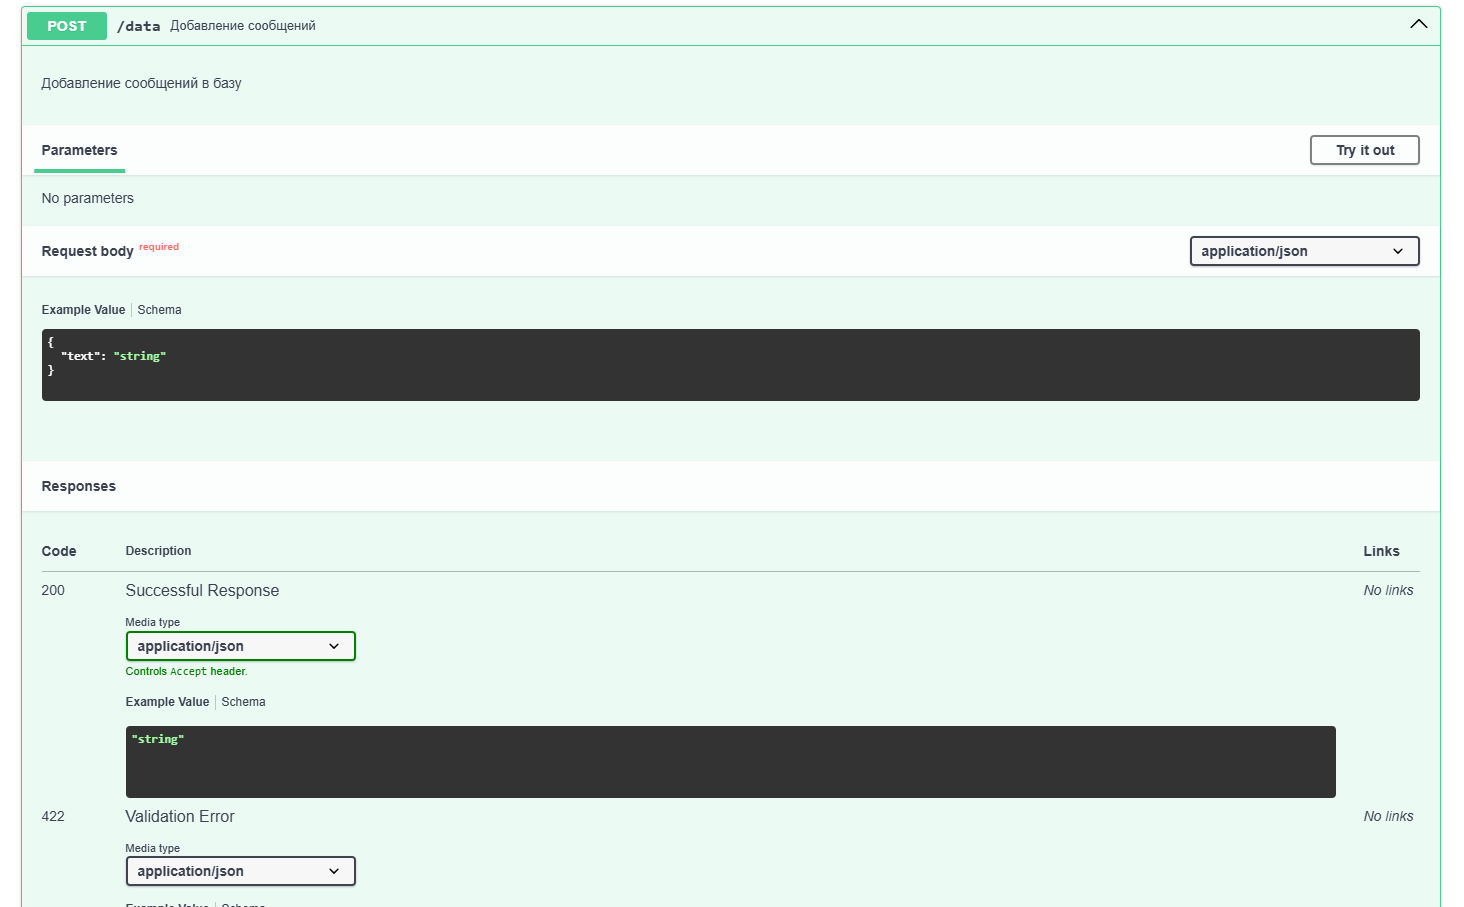